In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import sklearn
import matplotlib.pyplot as plt
import sys
from gensim.models import ldamodel, CoherenceModel
import gensim.corpora
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize
import re
import string
import spacy
import pickle

In [71]:
df = pd.read_csv('JEOPARDY_CSV.csv')
df.head()

,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams


In [72]:
df.columns = ['show_id', 'date', 'round', 'category', 'value', 'question', 'answer']

In [73]:
df['value'].replace({'None': '$0'}, inplace=True)

In [74]:
df['value'] = df['value'].apply(lambda x: int(x[1:].replace(',',''))) #remove $ remove comma and convert to int

In [75]:
df['year'] = df['date'].apply(lambda x: int(x[:4]))

In [76]:
df.head()

,show_id,date,round,category,value,question,answer,year
0,4680,2004-12-31,Jeopardy!,HISTORY,200,"For the last 8 years of his life, Galileo was ...",Copernicus,2004
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe,2004
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,200,The city of Yuma in this state has a record av...,Arizona,2004
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's,2004
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,200,"Signer of the Dec. of Indep., framer of the Co...",John Adams,2004


### Split df by value  
Here we split the data into groups based on question value. The analytical goal is to analyze the difficulty of questions across years by dollar value of each question. Therefore, it's important to only include values where the dollar value represents the difficulty of the question and ignore values like daily doubles and final jeopardy where the player determines the value of their response. Since the values on the board have changed over the years, we can't necessarily use the divisible-by-100 pattern that's used on Jeopardy today. Instead, we have taken \\$2000 as the maximum point value and binned all lower values into groups of \\$200.

In [41]:
df.value.unique()

array([  200,   400,   600,   800,  2000,  1000,  1200,  1600,  3200,
           0,  5000,   100,   300,   500,  1500,  4800,  1800,  1100,
        2200,  3400,  3000,  4000,  6800,  1900,  3100,   700,  1400,
        2800,  8000,  6000,  2400, 12000,  3800,  2500,  6200, 10000,
        7000,  1492,  7400,  1300,  7200,  2600,  3300,  5400,  4500,
        2100,   900,  3600,  2127,   367,  4400,  3500,  2900,  3900,
        4100,  4600, 10800,  2300,  5600,  1111,  8200,  5800,   750,
        7500,  1700,  9000,  6100,  1020,  4700,  2021,  5200,  3389,
        4200,     5,  2001,  1263,  4637,  3201,  6600,  3700,  2990,
        5500, 14000,  2700,  6400,   350,  8600,  6300,   250,  3989,
        8917,  9500,  1246,  6435,  8800,  2222,  2746, 10400,  7600,
        6700,  5100, 13200,  4300,  1407, 12400,  5401,  7800,  1183,
        1203, 13000, 11600, 14200,  1809,  8400,  8700, 11000,  5201,
        1801,  3499,  5700,   601,  4008,    50,  2344,  2811, 18000,
        1777,  3599,

In [42]:
# only take rows from Jeopardy and Double Jeopardy
df_ = df.loc[(df['round'] == 'Jeopardy!') | (df['round'] == 'Double Jeopardy!')]
#df _ df_[df_['value'].isin([3, 6])]

# only takes values <= $2000
df_ = df_[df_['value']<=2000]
df_ = df_.sort_values('value')

# bin dollar values into groups of every $200
bins =  np.arange(0, 18000, 200)
ind = np.digitize(df_['value'], bins)

# split into separate dfs based on dollar value of question
dfs= [x for _, x in df_.groupby(ind)]

# Perform LDA on each group separately

In [10]:
# adapted from https://towardsdatascience.com/topic-modeling-quora-questions-with-lda-nmf-aff8dce5e1dd
def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    return text

# Tokenize
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

# Stemming
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']): #'NOUN', 'ADJ', 'VERB', 'ADV'
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    all_stopwords = nlp.Defaults.stop_words
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags and token not in all_stopwords])
    return texts_out

In [11]:
def preprocessing(df):
    # takes df and completes all preprocessing steps (cleaning text, tokenization, lemmatization).
    # returns id2word and corpus
    d = pd.DataFrame(df.question.apply(lambda x: clean_text(x)))
    dw = list(sent_to_words(list(d.question)))
    lemm = lemmatization(dw, allowed_postags=['NOUN', 'VERB']) #select noun and verb
    id2word = gensim.corpora.Dictionary(lemm)
    corpus = [id2word.doc2bow(text) for text in lemm]
    return id2word, corpus

In [12]:
# adapted from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda
def compute_coherence_values(dictionary, corp, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        lda_model = ldamodel.LdaModel(corpus=corp, id2word=dictionary, num_topics=num_topics)
        coherencemodel = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

### Find best number of topics

In [135]:
id2word_g0, corpus_g0 = preprocessing(dfs[0])
_, coherence_values_g0 = compute_coherence_values(dictionary=id2word_g0, corp=corpus_g0, texts=lemm, start=2, limit=100, step=6)

In [137]:
id2word_g3, corpus_g3 = preprocessing(dfs[3])
_, coherence_values_g3 = compute_coherence_values(dictionary=id2word_g3, corp=corpus_g3, texts=lemm, start=2, limit=100, step=6)

In [138]:
id2word_g7, corpus_g7 = preprocessing(dfs[7])
_, coherence_values_g7 = compute_coherence_values(dictionary=id2word_g7, corp=corpus_g7, texts=lemm, start=2, limit=100, step=6)

In [139]:
id2word_g10, corpus_g10 = preprocessing(dfs[10])
_, coherence_values_g10 = compute_coherence_values(dictionary=id2word_g10, corp=corpus_g10, texts=lemm, start=2, limit=100, step=6)

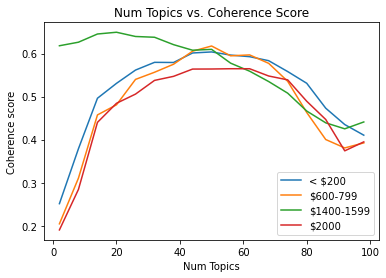

In [140]:
limit=100; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values_g0, label='< $200')
plt.plot(x, coherence_values_g3, label='$600-799')
plt.plot(x, coherence_values_g7, label='$1400-1599')
plt.plot(x, coherence_values_g10, label='$2000')

plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.title('Num Topics vs. Coherence Score')
plt.legend()
plt.show()

It looks like around 50 topics is best for these sets.

### Run LDA on each group individually (models are saved don't need to rerun)

In [44]:
# takes about 8 min to run
models = []
corpuses = []
id2words = []
for df in dfs:
    id2word, corpus = preprocessing(df)
    corpuses.append(corpus)
    id2words.append(id2words)
    model = ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=50)
    models.append(model)

In [45]:
len(models)

11

In [187]:
filename = '/Users/Lucia/Documents/USF/MSDS626_Case_Studies/jeopardy-topic-modeling/data_2a/corpuses'
outfile = open(filename,'wb')
pickle.dump(corpuses, outfile)
outfile.close()

In [188]:
filename = '/Users/Lucia/Documents/USF/MSDS626_Case_Studies/jeopardy-topic-modeling/data_2a/id2words'
outfile = open(filename,'wb')
pickle.dump(id2words, outfile)
outfile.close()

In [189]:
filename = '/Users/Lucia/Documents/USF/MSDS626_Case_Studies/jeopardy-topic-modeling/data_2a/trained_models'
outfile = open(filename,'wb')
pickle.dump(models,outfile)
outfile.close()

### Load saved data

In [46]:
filename = './data_2a/corpuses'
infile = open(filename,'rb')
corpuses = pickle.load(infile)
infile.close()

In [47]:
filename = './data_2a/id2words'
infile = open(filename,'rb')
id2words = pickle.load(infile)
infile.close()

In [16]:
filename = './data_2a/trained_models'
infile = open(filename,'rb')
models = pickle.load(infile)
infile.close()

In [48]:
def get_lda_topics(model, num_topics):
    word_dict = {};
    for i in range(num_topics):
        words = model.show_topic(i, topn = 15);
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words];
    return pd.DataFrame(word_dict);

get_lda_topics(models[0], 50)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10,...,Topic # 41,Topic # 42,Topic # 43,Topic # 44,Topic # 45,Topic # 46,Topic # 47,Topic # 48,Topic # 49,Topic # 50
0,character,be,be,be,be,be,son,be,be,be,...,go,dog,group,man,be,be,be,series,make,day
1,be,number,river,foot,have,place,be,school,keep,line,...,stand,be,be,be,run,love,mean,be,be,be
2,include,university,world,find,work,city,christmas,serve,usa,night,...,team,open,set,bill,die,george,name,park,term,family
3,know,college,follow,visit,history,blow,device,island,wear,variety,...,make,month,name,job,end,type,start,share,paper,fight
4,product,write,refer,measure,type,mayor,beer,john,chocolate,father,...,horse,send,leader,say,look,return,elect,sea,shoot,drop
5,singer,have,sign,hill,movie,box,soda,ship,theater,wife,...,ball,church,jame,version,clue,member,tree,child,use,cross
6,name,site,lady,city,tv,produce,robert,war,hat,soup,...,century,discover,rhyme,level,movie,know,california,flag,david,tom
7,hero,charle,office,originate,walter,detective,come,gold,state,wood,...,need,state,head,love,accord,bull,player,smith,sitcom,kind
8,cheese,cat,disney,life,club,ground,say,france,empire,peace,...,be,south,comedy,lover,believe,actress,rank,radio,substance,note
9,organ,thing,length,stamp,say,dress,have,explorer,drink,launch,...,september,indicate,june,troop,cast,system,city,see,pie,place


### Analysis of lda by value

## Split each group further by year

In [49]:
dfs_val0_year = [x for _, x in dfs[0].groupby('year')]

In [50]:
len(dfs_val0_year)

28

In [50]:
# 29 x 64 = 1856 lda models lol

In [51]:
dfs_val_year = [[x for _, x in dfs[i].groupby('year')] for i in range(len(dfs))]

In [70]:
df.head()

,show_id,date,round,category,value,question,answer,year
1971,6294,2012-01-19,Double Jeopardy!,THE LIVING PLANET,2000,The April 2009 issue of Science magazine repor...,their genome,2012
1973,6294,2012-01-19,Double Jeopardy!,4 N,2000,"Inopportune or untimely, like the title ""woman...",inconvenient,2012
1972,6294,2012-01-19,Double Jeopardy!,ACTING PRESIDENTS ON TV,2000,Mary McDonnell as Laura Roslin,Battlestar Galactica,2012
4508,6288,2012-01-11,Jeopardy!,TRAVEL,2000,"This island's Mataveri Intl. Airport, the worl...",Easter Island,2012
4553,6288,2012-01-11,Double Jeopardy!,THE DE NIRO CODE,2000,"""Goodfellas"": ""The two greatest things in life...",your friends,2012


In [69]:
filename = './data_1a/corpus'
infile = open(filename,'rb')
corpus = pickle.load(infile)
infile.close()

filename = './data_1a/lda_trained.id2word'
infile = open(filename,'rb')
id2word = pickle.load(infile)
infile.close()

filename = './data_1a/lda_trained'
lda = ldamodel.LdaModel.load(filename)

In [154]:
def get_lda_topics(model, num_topics):
    word_dict = {};
    for i in range(num_topics):
        words = model.show_topic(i, topn = 20);
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words];
    return pd.DataFrame(word_dict);

#get_lda_topics(lda, 20)

In [80]:
most_likely_topic=[]
for doc in corpus:
    likelihoods = dict(lda.get_document_topics(doc))
    most_likely_topic.append(max(likelihoods,key=likelihoods.get))

In [ ]:
df['topic'] = most_likely_topic

In [94]:
df

,show_id,date,round,category,value,question,answer,year,topic
0,4680,2004-12-31,Jeopardy!,HISTORY,200,"For the last 8 years of his life, Galileo was ...",Copernicus,2004,4
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe,2004,2
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,200,The city of Yuma in this state has a record av...,Arizona,2004,17
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's,2004,16
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,200,"Signer of the Dec. of Indep., framer of the Co...",John Adams,2004,13
...,...,...,...,...,...,...,...,...,...
216925,4999,2006-05-11,Double Jeopardy!,RIDDLE ME THIS,2000,This Puccini opera turns on the solution to 3 ...,Turandot,2006,3
216926,4999,2006-05-11,Double Jeopardy!,"""T"" BIRDS",2000,In North America this term is properly applied...,a titmouse,2006,3
216927,4999,2006-05-11,Double Jeopardy!,AUTHORS IN THEIR YOUTH,2000,"In Penny Lane, where this ""Hellraiser"" grew up...",Clive Barker,2006,9
216928,4999,2006-05-11,Double Jeopardy!,QUOTATIONS,2000,"From Ft. Sill, Okla. he made the plea, Arizona...",Geronimo,2006,11


In [87]:
# only take rows from Jeopardy and Double Jeopardy
df_ = df.loc[(df['round'] == 'Jeopardy!') | (df['round'] == 'Double Jeopardy!')]
#df _ df_[df_['value'].isin([3, 6])]

# only takes values <= $2000
df_ = df_[df_['value']<=2000]
df_ = df_.sort_values('value')

# bin dollar values into groups of every $200
bins =  np.arange(0, 18000, 200)
ind = np.digitize(df_['value'], bins)

In [112]:
df_.head()

,show_id,date,round,category,value,question,answer,year,topic,value_group
99369,4332,2003-06-03,Double Jeopardy!,MACHINES,5,(Jimmy of the Clue Crew at Carnegie Mellon Uni...,automaton,2003,16,1
90802,4204,2002-12-05,Double Jeopardy!,12-LETTER WORDS,5,"From the Latin for ""to correct"", it's an adjec...",incorrigible,2002,16,1
75426,4643,2004-11-10,Double Jeopardy!,TRAVEL,5,The Peer Gynt ski area has been called this co...,Norway,2004,11,1
160647,5126,2006-12-18,Double Jeopardy!,LONG LIVE THE KING,5,In 1964 Elvis bought a yacht owned by this ex-...,FDR,2006,17,1
20789,496,1986-11-03,Jeopardy!,LEAD SINGERS,5,"[Audio] Called ""Buffoons of '60s British Rock ...",Freddie And The Dreamers,1986,15,1


In [107]:
df_['value_group'] = ind

In [113]:
df_.head()

,show_id,date,round,category,value,question,answer,year,topic,value_group
99369,4332,2003-06-03,Double Jeopardy!,MACHINES,5,(Jimmy of the Clue Crew at Carnegie Mellon Uni...,automaton,2003,16,1
90802,4204,2002-12-05,Double Jeopardy!,12-LETTER WORDS,5,"From the Latin for ""to correct"", it's an adjec...",incorrigible,2002,16,1
75426,4643,2004-11-10,Double Jeopardy!,TRAVEL,5,The Peer Gynt ski area has been called this co...,Norway,2004,11,1
160647,5126,2006-12-18,Double Jeopardy!,LONG LIVE THE KING,5,In 1964 Elvis bought a yacht owned by this ex-...,FDR,2006,17,1
20789,496,1986-11-03,Jeopardy!,LEAD SINGERS,5,"[Audio] Called ""Buffoons of '60s British Rock ...",Freddie And The Dreamers,1986,15,1


In [116]:
df_.groupby(['value_group', 'year', 'topic']).count()

show_id  date  round  category  value  question  \
value_group year topic                                                    
1           1984 0           18    18     18        18     18        18   
                 1            8     8      8         8      8         8   
                 2            7     7      7         7      7         7   
                 3            5     5      5         5      5         5   
                 4            4     4      4         4      4         4   
...                         ...   ...    ...       ...    ...       ...   
11          2012 15           7     7      7         7      7         7   
                 16           7     7      7         7      7         7   
                 17           3     3      3         3      3         3   
                 18           6     6      6         6      6         6   
                 19           3     3      3         3      3         3   

                        answer  
value_group year topic          
1           1984 0          18  
                 1           8  
                 2           7  
                 3           5  
                 4           4  
...                        ...  
11          2012 15          7  
                 16          7  
                 17          3  
                 18          6  
                 19          3  

[4830 rows x 7 columns]

In [131]:
t = df_.groupby(['year', 'value_group', 'topic']).size().to_frame('count').reset_index()
t

,year,value_group,topic,count
0,1984,1,0,18
1,1984,1,1,8
2,1984,1,2,7
3,1984,1,3,5
4,1984,1,4,4
...,...,...,...,...
4825,2012,11,15,7
4826,2012,11,16,7
4827,2012,11,17,3
4828,2012,11,18,6


In [137]:
import seaborn as sns

### Time series of topics per value group

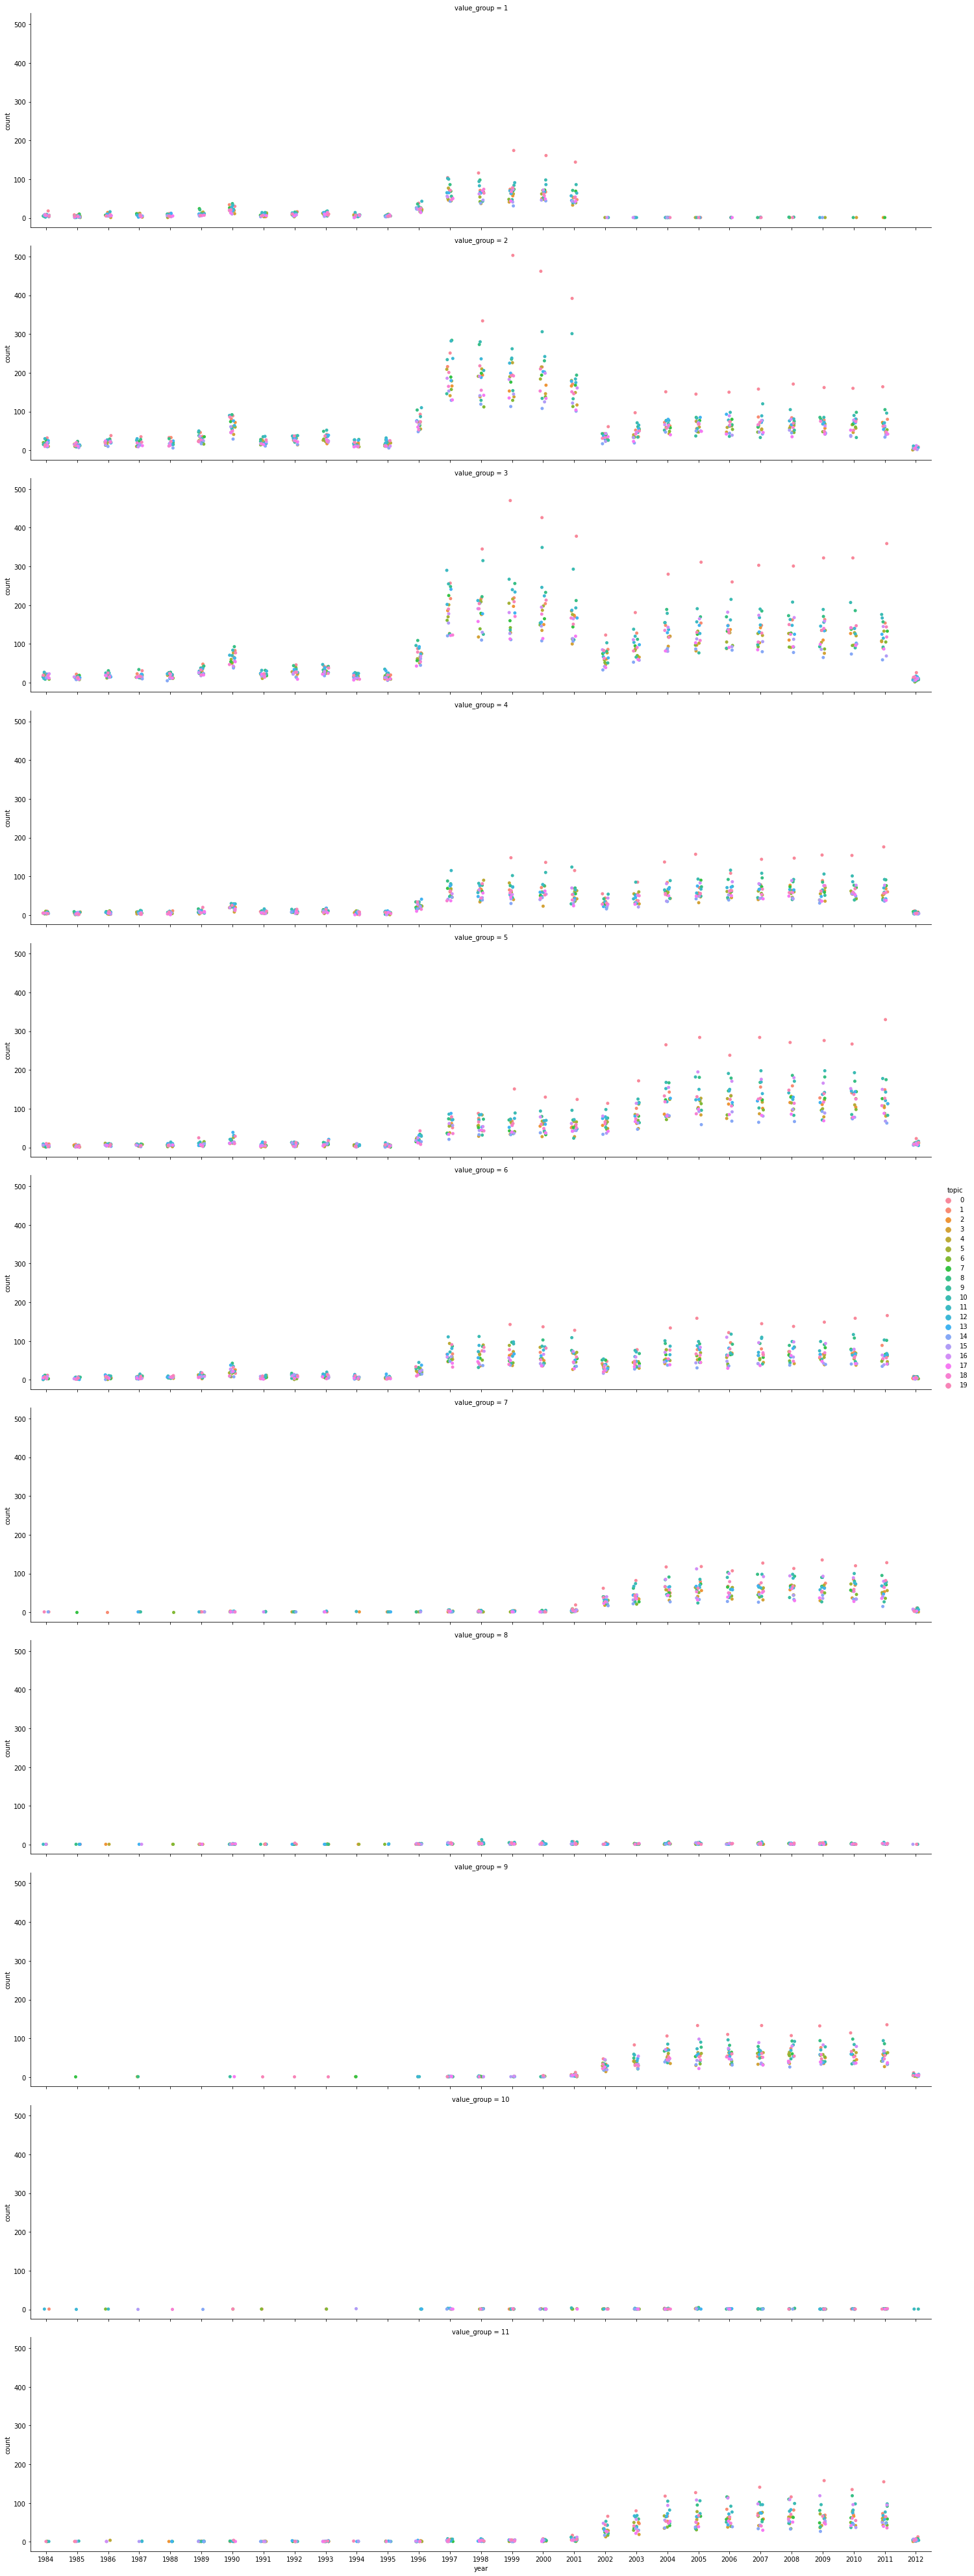

In [153]:
sns.catplot(x='year', y='count', hue='topic', row='value_group', data=t, height=5, aspect=4)

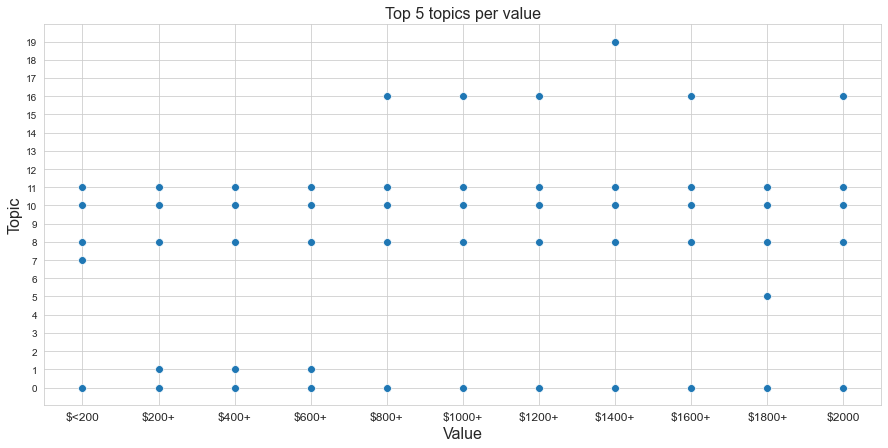

In [165]:
a = df_.groupby(['value_group','topic']).size().to_frame('count').reset_index()
a = a.sort_values(['value_group','count'], ascending=[True,False])
topk_topics = a.groupby('value_group').head(5).reset_index()
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(15,7))
bins = ['$<200', '$200+', '$400+', '$600+', '$800+', '$1000+',\
 '$1200+', '$1400+', '$1600+', '$1800+', '$2000']
sns.scatterplot(x=topk_topics['value_group'], y=topk_topics['topic'], s=60)
ax.set_title('Top 5 topics per value', size=16)
ax.set_xticks(range(1,12))
ax.set_xticklabels(bins, size=12)
ax.set_yticks(range(20))
ax.set_xlabel('Value', size=16)
ax.set_ylabel('Topic', size=16)
plt.show()

### Top 5 topics per year per value group

In [218]:
temp = []
for year in t.year.unique():
    temp_df = t[t['year']==year].copy()
    temp_df = temp_df.sort_values(['value_group', 'count'], ascending=[True,False]).groupby('value_group').head(5)
    temp.append(temp_df)
top5_year = pd.concat(temp)

In [224]:
#top5_year

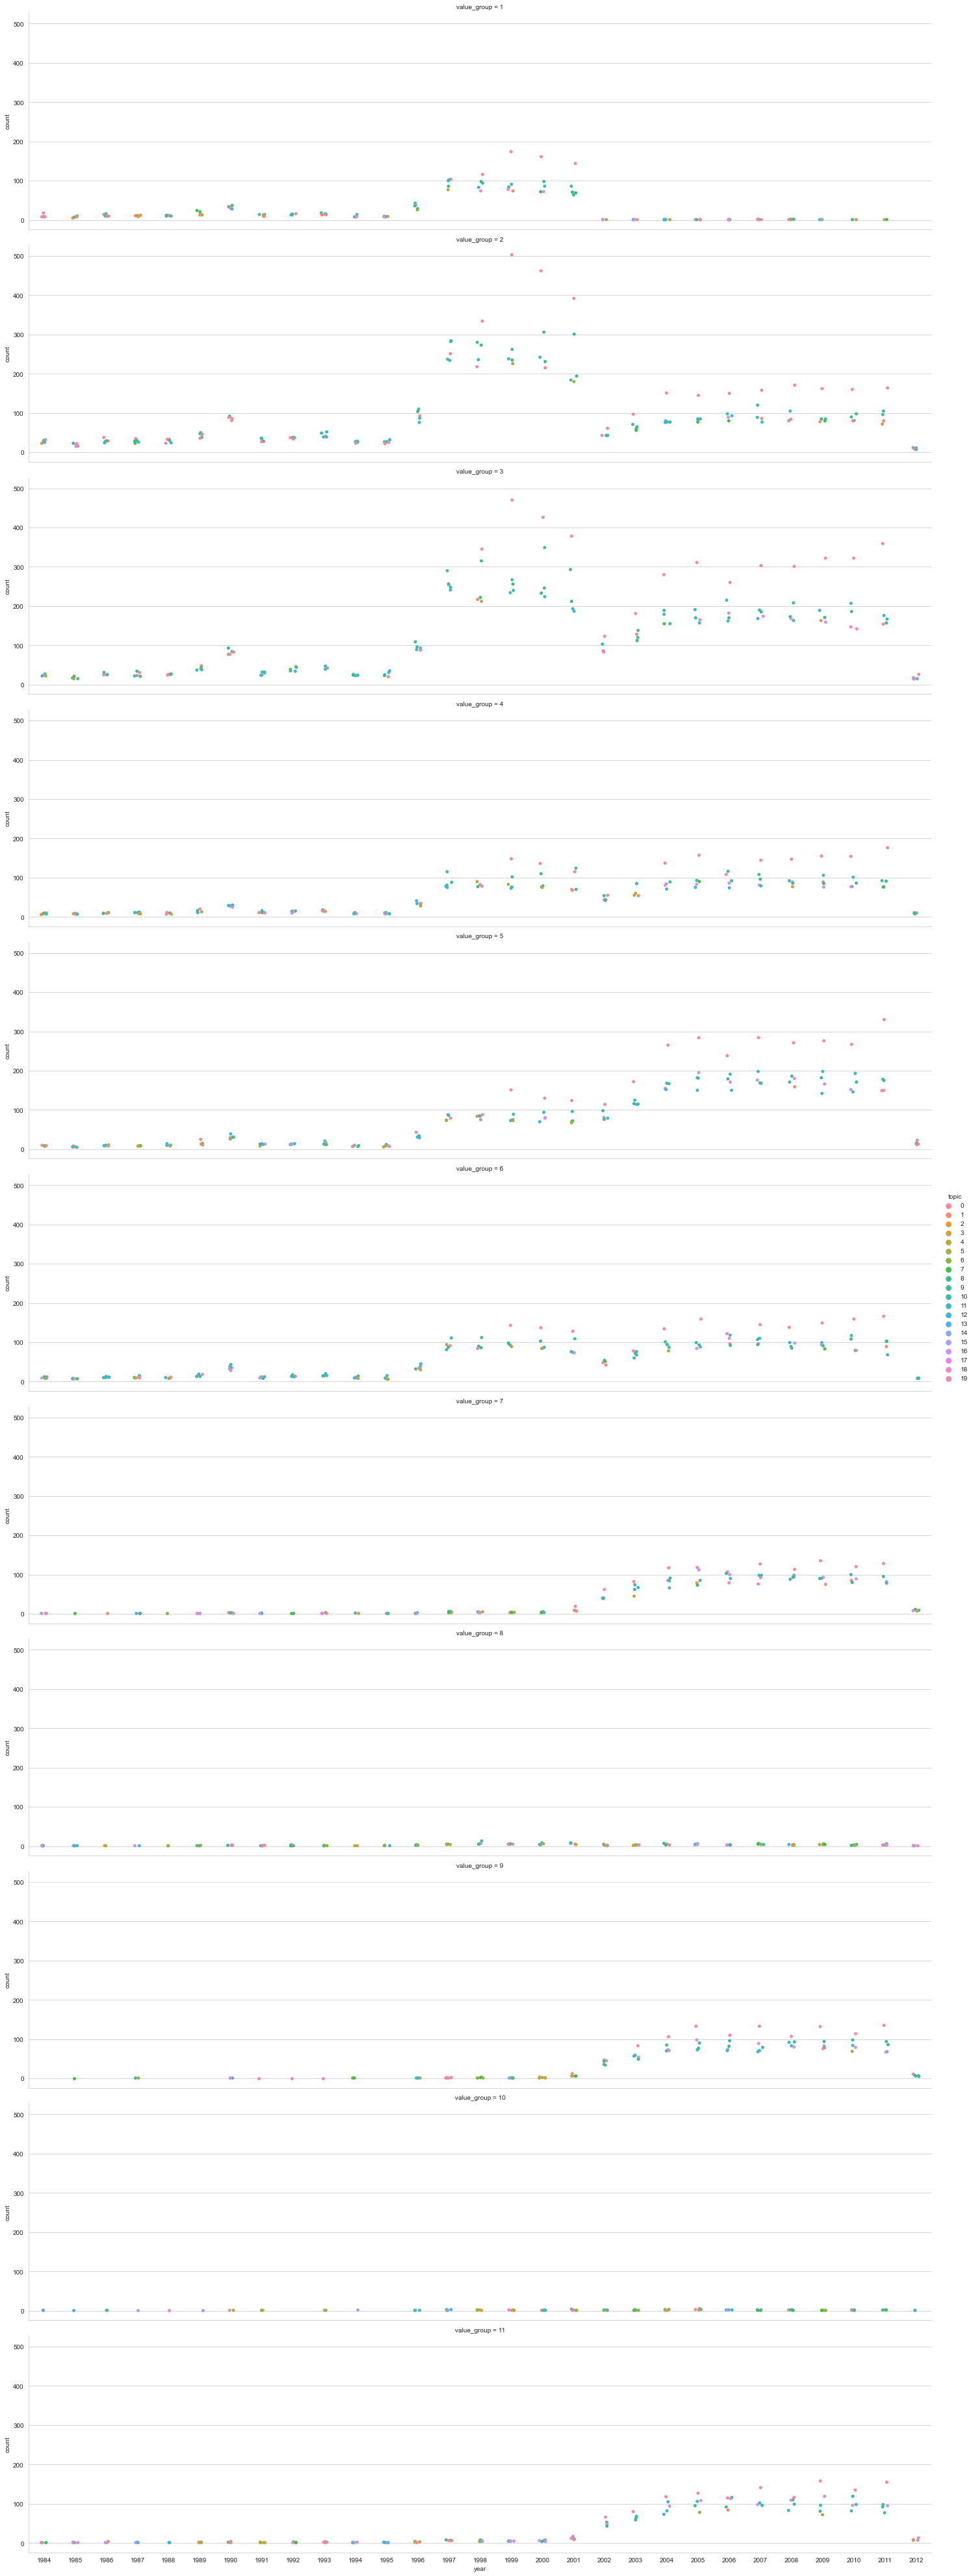

In [222]:
sns.catplot(x='year', y='count', hue='topic', row='value_group', data=top5_year, height=5, aspect=4)

### Difficulty over the years by topic based on value_group

In [276]:
test = df_.groupby(['year', 'topic', 'value_group']).size().to_frame('count').reset_index()
test

,year,topic,value_group,count
0,1984,0,1,18
1,1984,0,2,32
2,1984,0,3,23
3,1984,0,4,10
4,1984,0,5,10
...,...,...,...,...
4825,2012,19,6,7
4826,2012,19,7,3
4827,2012,19,8,1
4828,2012,19,9,4


### Create a list of lists that include the year, topic number, and the weighted frequency

## weighted frequency $ = \frac{ \sum \limits _{i=1} ^{n} count_{i}*(value group)_{i} }{ \sum \limits _{i=1} ^{n} count_{i}}$

In [321]:
w_freq = []
for topic in test.topic.unique():
    inter = test[test.topic==topic]
    for year in inter.year.unique():
        temp_df = inter[inter['year']==year]
        freq = (temp_df['value_group']*temp_df['count']).sum() / temp_df['count'].sum()
        w_freq.append([year, topic, freq])

In [378]:
#w_freq

In [328]:
freq_df = pd.DataFrame(sorted(w_freq, key=lambda x: x[0]), columns=['year', 'topic', 'w_freq'])
freq_df

,year,topic,w_freq
0,1984,0,3.065421
1,1984,1,3.206349
2,1984,2,3.029412
3,1984,3,2.651163
4,1984,4,3.500000
...,...,...,...
575,2012,15,5.934783
576,2012,16,5.283333
577,2012,17,5.307692
578,2012,18,5.360000


### For each year, rank each topic according to their weighted frequency relative to the other topics

In [361]:
topic_ranks = np.array([], dtype=int)
for year in freq_df.year.unique():
    vals = freq_df[freq_df['year']==year]['w_freq'].values
    temp = vals.argsort()
    ranks = np.empty_like(temp)
    ranks[temp] = np.arange(len(vals)) + 1  # Ensure the ranks are from 1-20
    topic_ranks = np.concatenate((topic_ranks, ranks))

In [364]:
freq_df['ranks'] = topic_ranks
freq_df

,year,topic,w_freq,ranks,w_rank
0,1984,0,3.065421,10,27.588785
1,1984,1,3.206349,15,44.888889
2,1984,2,3.029412,9,24.235294
3,1984,3,2.651163,1,0.000000
4,1984,4,3.500000,20,66.500000
...,...,...,...,...,...
575,2012,15,5.934783,19,106.826087
576,2012,16,5.283333,7,31.700000
577,2012,17,5.307692,8,37.153846
578,2012,18,5.360000,9,42.880000


### Calculate the weighted average for each year based on the ranks and weighted frequency of each topic

## weighted frequency $ = \frac{ \sum \limits _{i=1} ^{n} (weighted  frequency)_{i}*(rank)_{i} }{ \sum \limits _{i=1} ^{n} (weighted  frequency)_{i}}$

In [365]:
freq_df['w_rank'] = freq_df['w_freq'] * freq_df['ranks']
freq_df

,year,topic,w_freq,ranks,w_rank
0,1984,0,3.065421,10,30.654206
1,1984,1,3.206349,15,48.095238
2,1984,2,3.029412,9,27.264706
3,1984,3,2.651163,1,2.651163
4,1984,4,3.500000,20,70.000000
...,...,...,...,...,...
575,2012,15,5.934783,19,112.760870
576,2012,16,5.283333,7,36.983333
577,2012,17,5.307692,8,42.461538
578,2012,18,5.360000,9,48.240000


In [367]:
final_freq = freq_df.groupby('year').sum().reset_index()
final_freq['w_avg'] = final_freq['w_rank'] / final_freq['w_freq']
final_freq

,year,topic,w_freq,ranks,w_rank,w_avg
0,1984,190,61.043758,210,666.578059,10.919676
1,1985,190,62.312506,210,685.622410,11.002966
2,1986,190,62.274387,210,679.832437,10.916726
3,1987,190,63.156423,210,693.220613,10.976249
4,1988,190,63.150743,210,687.865866,10.892443
5,1989,190,63.227340,210,693.357895,10.966109
6,1990,190,62.755037,210,678.985259,10.819614
7,1991,190,63.327092,210,689.472796,10.887485
8,1992,190,62.582918,210,678.056864,10.834536
9,1993,190,63.503922,210,691.685236,10.892008


### Plot of the average difficulty over the years based on the topics and their frequency in each value group

(1983.0, 2013.0)

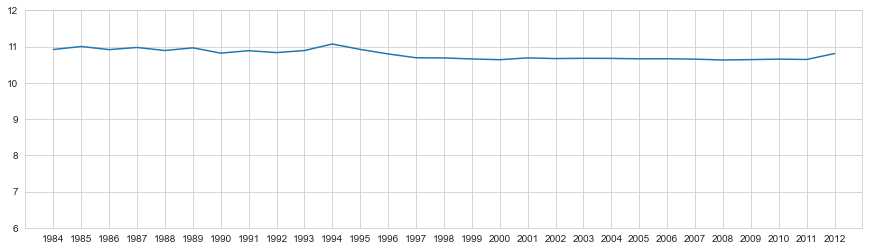

In [377]:
fig, ax = plt.subplots(figsize=(15,4))
ax.plot(final_freq['year'], final_freq['w_avg'])
ax.set_ylim(6, 12)
ax.set_xticks(range(1984, 2013))
ax.set_xlim(1983, 2013)